In [119]:
# Import libraries
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

## 1. Data Preparation

- Load the data
- Inspect the data
- Data cleaning

In [120]:
# Load data
df = pd.read_csv('data/wholesale_customer_data.csv')
print(f'Dataset Dimension: ', df.shape)
df.head()

Dataset Dimension:  (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


**Inspect Data**

In [121]:
# Inspect data
# Descriptive summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


From the overview, there are no missing value, all dtypes are `int64` dtype which needs cleaning since some of the columns are of categorical type

In [122]:
# Inspect duplicates
print(f'Number of Duplicates: ', df.duplicated().sum())
# Statistical summary
df.describe()

Number of Duplicates:  0


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Our data columns have some level of skewness 

In [123]:
df[['Fresh', 'Milk', 'Grocery','Frozen', 'Detergents_Paper', 'Delicassen']].skew()

Fresh                2.561323
Milk                 4.053755
Grocery              3.587429
Frozen               5.907986
Detergents_Paper     3.631851
Delicassen          11.151586
dtype: float64

In [124]:
# skewed_cols = ['Fresh', 'Milk', 'Grocery','Frozen', 'Detergents_Paper', 'Delicassen']
# for col in skewed_cols:
#     sns.histplot(df[col], kde=True)
#     plt.show()

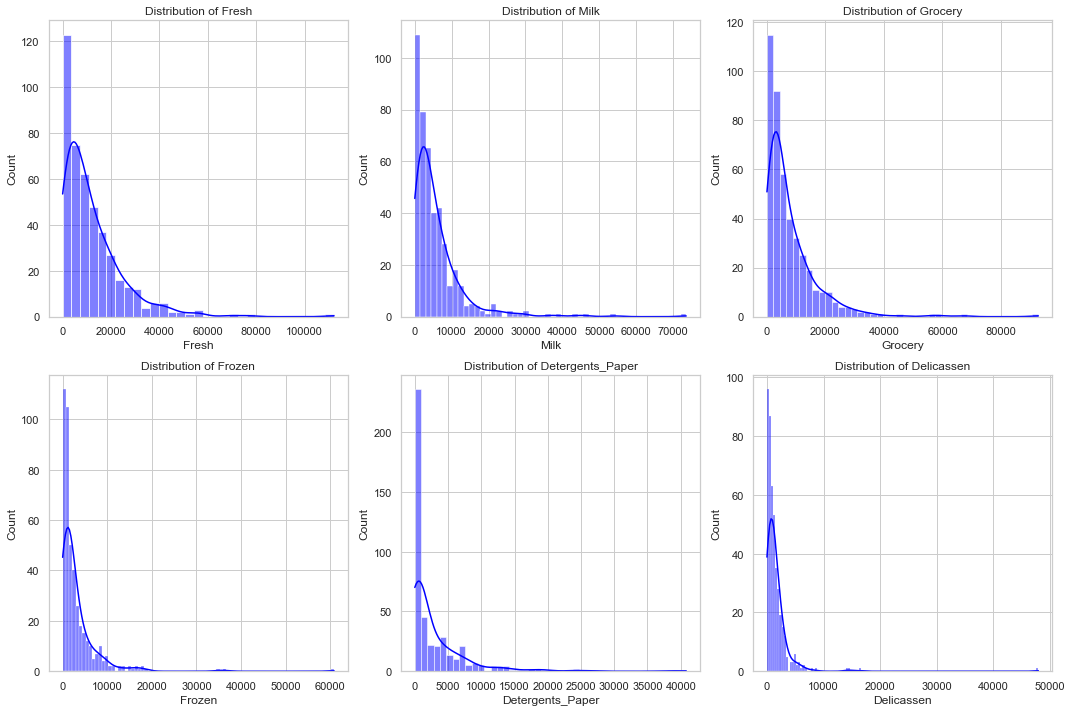

In [125]:
# List of skewed columns
skewed_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Determine grid size (rows and columns)
n_cols = 3  # Number of columns in the grid
n_rows = -(-len(skewed_cols) // n_cols)  # Ceiling division for rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot each column in its corresponding subplot
for i, col in enumerate(skewed_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of {col}')

# Hide any unused subplots
for j in range(len(skewed_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

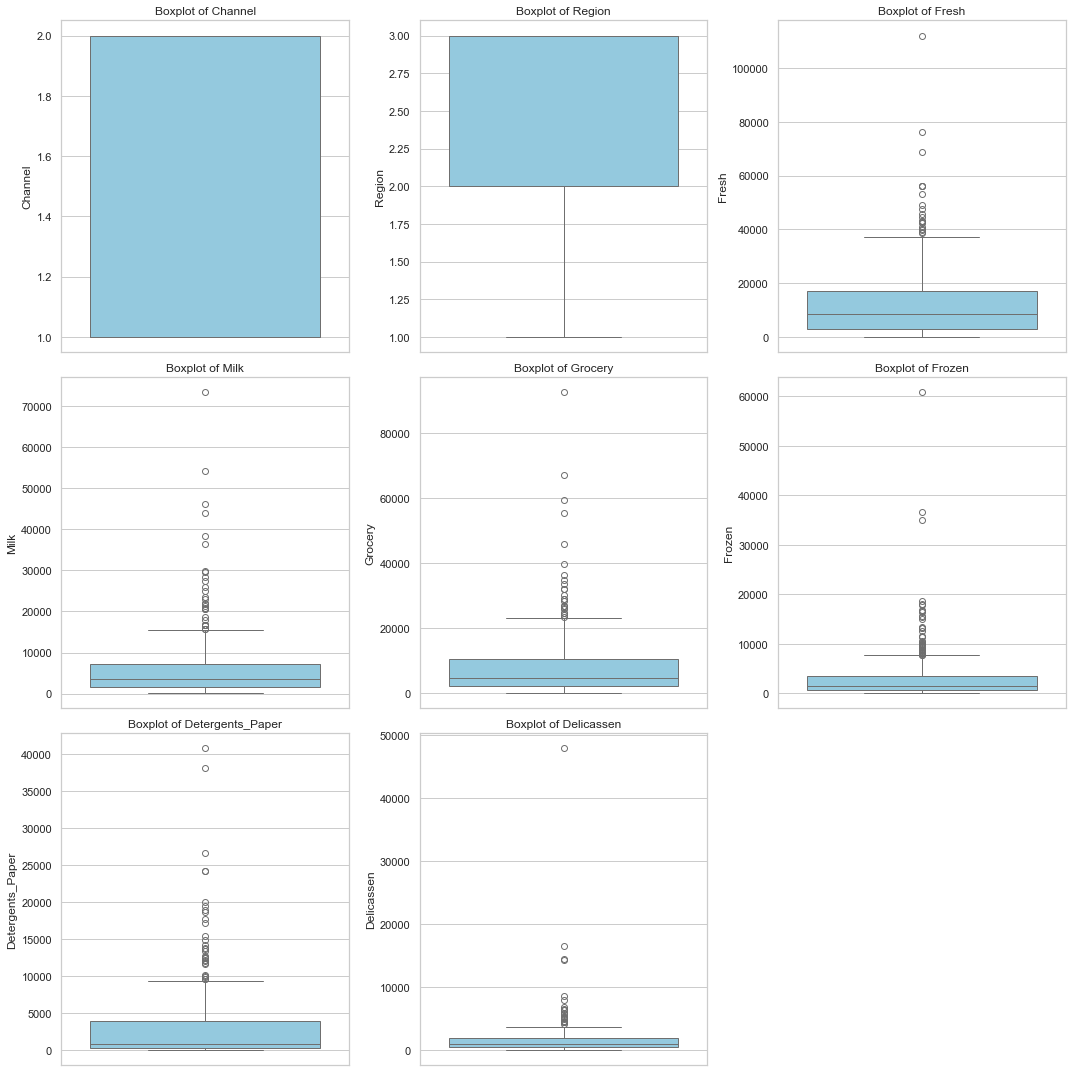

In [126]:
# Create boxplots for all numeric columns
# Number of numeric columns
num_cols = len(df.columns)

# Calculate grid size
n_cols = 3  # Number of columns in the grid
n_rows = -(-num_cols // n_cols)  # Ceiling division to determine rows

# Create the subplots
plt.figure(figsize=(15, 5 * n_rows))  # Adjust figure size dynamically
for i, col in enumerate(df.columns, 1):
    plt.subplot(n_rows, n_cols, i)  # Dynamically create subplots
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

**Data Cleaning**

In [127]:
# Correct column datatypes
# Categorical columns
df[['Channel', 'Region']] = df[['Channel', 'Region']].astype('category')
# Convert to 'floats'
monetary_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df[monetary_cols] = df[monetary_cols].astype('float')
# Check 
df.head(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669.0,9656.0,7561.0,214.0,2674.0,1338.0
1,2,3,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0
2,2,3,6353.0,8808.0,7684.0,2405.0,3516.0,7844.0


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Channel           440 non-null    category
 1   Region            440 non-null    category
 2   Fresh             440 non-null    float64 
 3   Milk              440 non-null    float64 
 4   Grocery           440 non-null    float64 
 5   Frozen            440 non-null    float64 
 6   Detergents_Paper  440 non-null    float64 
 7   Delicassen        440 non-null    float64 
dtypes: category(2), float64(6)
memory usage: 21.9 KB


In [129]:
# Normalize numerical columns
numeric_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df_normalized = df.copy()
df_normalized[numeric_cols] = df_normalized[numeric_cols].apply(np.log1p)
df_normalized.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678
1,2,3,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682
2,2,3,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632
3,1,3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412
4,2,3,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718


In [130]:
df_normalized[['Fresh', 'Milk', 'Grocery','Frozen', 'Detergents_Paper', 'Delicassen']].skew()

Fresh              -1.575326
Milk               -0.224063
Grocery            -0.674938
Frozen             -0.352655
Detergents_Paper   -0.235961
Delicassen         -1.091827
dtype: float64

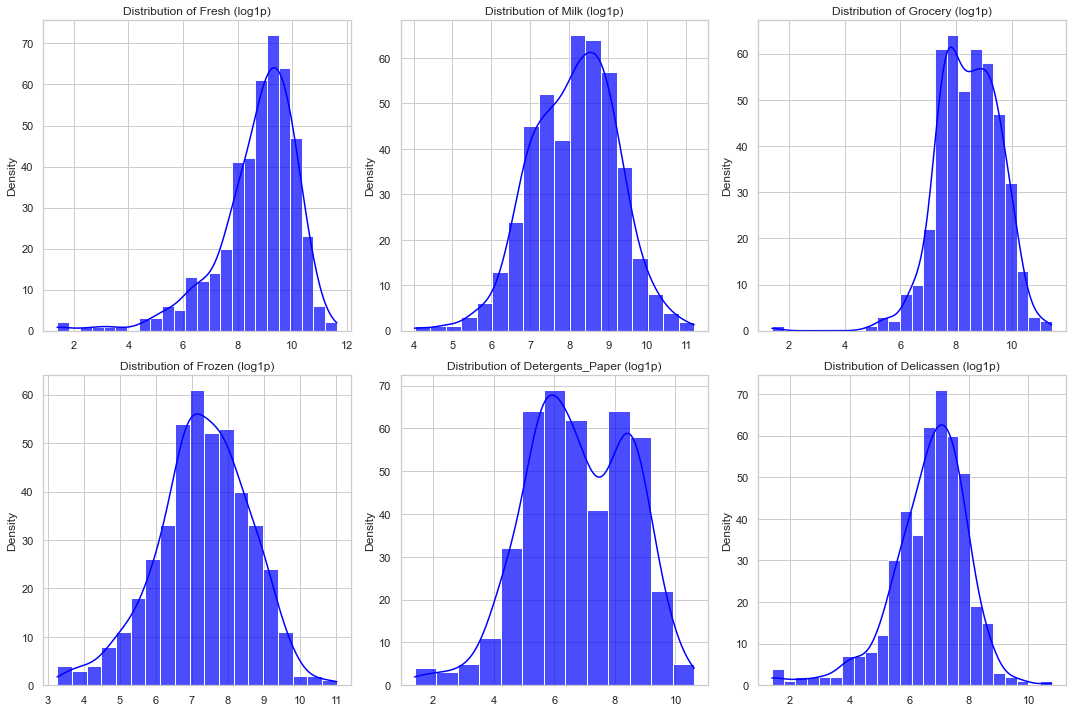

In [131]:
# Plot distributions of the normalized columns in a grid structure
n_cols = 3 
n_rows = -(-len(numeric_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df_normalized[col], kde=True, ax=axes[i], color='blue', alpha=0.7)
    axes[i].set_title(f'Distribution of {col} (log1p)')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()

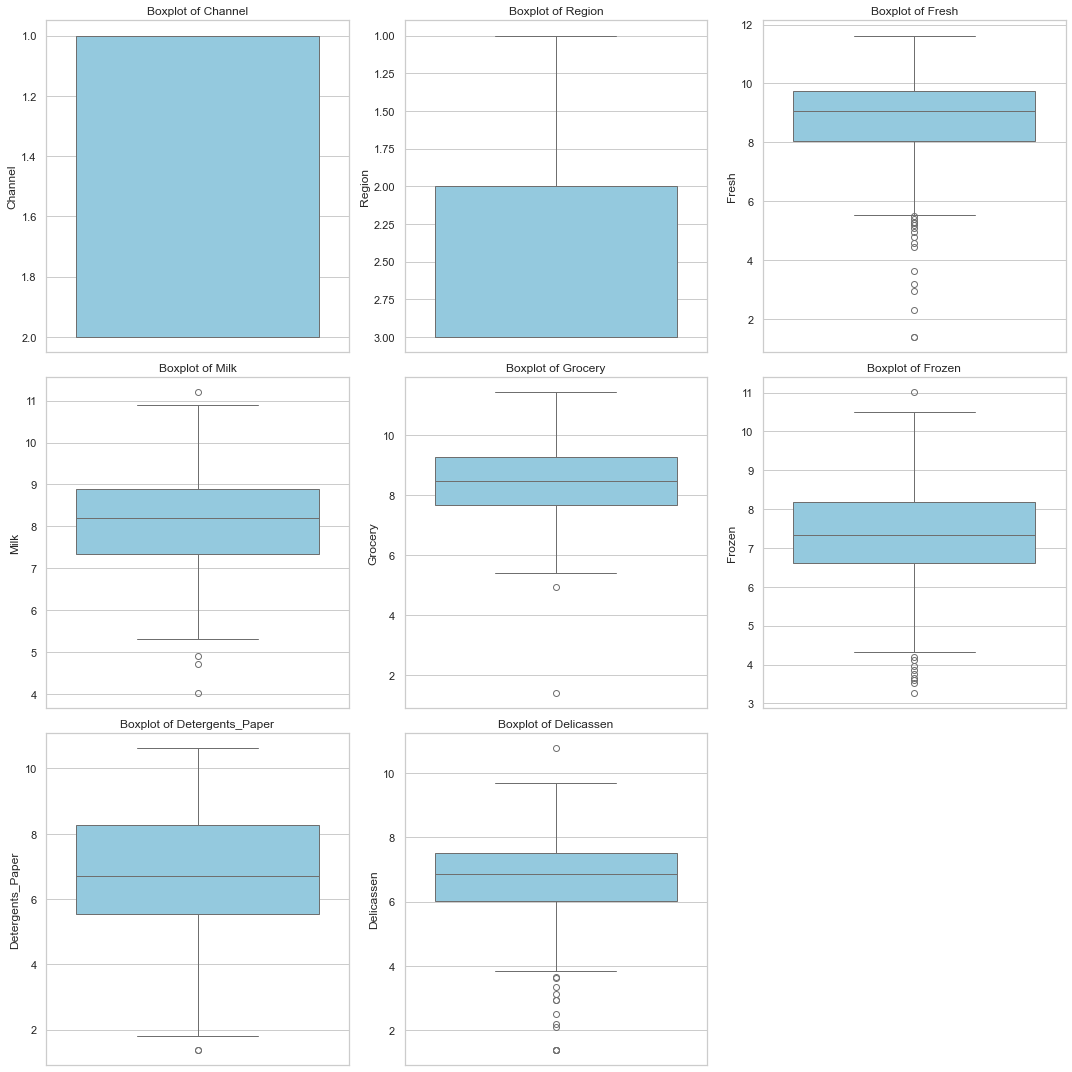

In [132]:
# Outliers detection
# Create boxplots for all numeric columns
# Number of numeric columns
num_cols = len(df_normalized.columns)

# Calculate grid size
n_cols = 3  # Number of columns in the grid
n_rows = -(-num_cols // n_cols)  # Ceiling division to determine rows

# Create the subplots
plt.figure(figsize=(15, 5 * n_rows))  # Adjust figure size dynamically
for i, col in enumerate(df_normalized.columns, 1):
    plt.subplot(n_rows, n_cols, i)  # Dynamically create subplots
    sns.boxplot(y=df_normalized[col], color='skyblue')
    plt.title(f'Boxplot of {col}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

There's an overall improvent in skewness which is important for clustering.

## 2. Exploratory Data Analysis

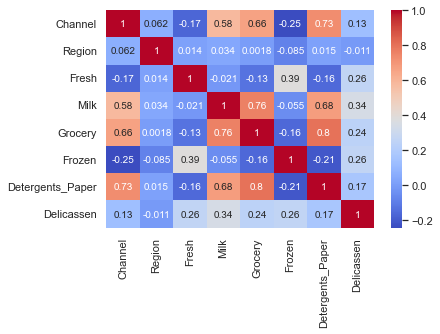

In [133]:
# Correlation Matrix
corr = df_normalized.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## 3. Clustering
Segment customers into meaningful groups based on their spending patterns.

In [134]:
# Scaling data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_normalized.iloc[:, 2:]) # We're only interested in spending columns

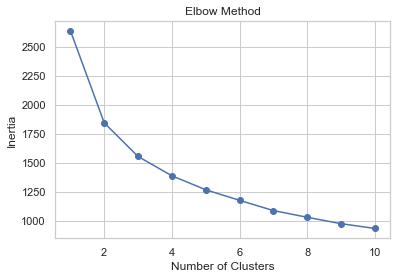

In [135]:
# K-Means clustering
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Elbow plot for optimal k
plt.plot(range(1,11), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia");

In [136]:
# # Cluster analysis (Fit K-Means with optimal K)
# kmeans = KMeans(n_clusters=3, random_state=42)
# df_normalized['Cluster'] = kmeans.fit_predict(scaled_data)

In [137]:
# print(f'CH_Score: ', calinski_harabasz_score(df_normalized, df_normalized['Cluster']))

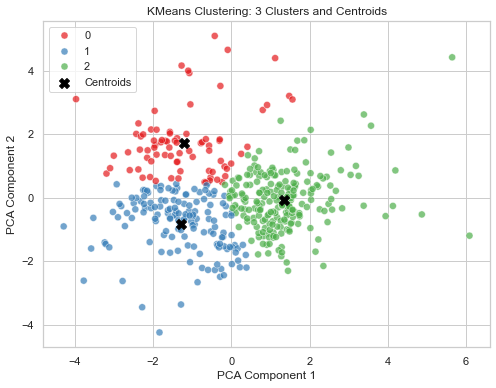

In [144]:
kmeans2 = KMeans(n_clusters=3, random_state=42)
kmeans2.fit(scaled_data)
labels = kmeans2.labels_
centroids = kmeans2.cluster_centers_
df_normalized['Cluster'] = kmeans2.predict(scaled_data) # Evaluation purposes

# Perform PCA to reduce data for 2D visualization
pca2 = PCA(n_components=2)
pca_components2 = pca2.fit_transform(scaled_data)

# Create df for easier plotting
df_pca = pd.DataFrame(pca_components2, columns=['PCA1', 'PCA2'])
df_pca['Cluster2'] = labels

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster2', data=df_pca, palette='Set1', s=50, alpha=0.7)

# Plot centroids
centroid_pca = pca2.transform(centroids)  # Transform centroids to 2D
plt.scatter(centroid_pca[:, 0], centroid_pca[:, 1], s=100, c='black', marker='X', label='Centroids')

# Labeling the plot
plt.title('KMeans Clustering: 3 Clusters and Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [145]:
calinski_harabasz_score(scaled_data, df_normalized['Cluster'])

152.8351876500921

## 4. Classification

Predict Customer type e.g. Horeca or Retail using classification models.

- Define features and Target: Spending Data as Features and Channel as Target variable
- Split Data

In [140]:
# Select features
X = df_normalized.iloc[:, 2:-1]
y = df_normalized['Channel']
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [141]:
# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [142]:
# Evaluate model
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8863636363636364
              precision    recall  f1-score   support

           1       0.97      0.88      0.92        65
           2       0.72      0.91      0.81        23

    accuracy                           0.89        88
   macro avg       0.85      0.89      0.86        88
weighted avg       0.90      0.89      0.89        88



In [146]:
df_normalized

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678,1
1,2,3,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682,1
2,2,3,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632,1
3,1,3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412,2
4,2,3,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718,1
...,...,...,...,...,...,...,...,...,...
435,1,3,10.299037,9.396986,9.682092,9.483112,5.209486,7.698483,1
436,1,3,10.577172,7.266827,6.639876,8.414274,4.543295,7.760893,2
437,2,3,9.584108,9.647885,10.317053,6.082219,9.605216,7.532624,1
438,1,3,9.239025,7.591862,7.711101,6.946014,5.129899,7.661998,2


### 5. Feature Engineering (Advanced/Optional)
- Total Spending : Sum of all spending categories
- Spending Ratios : Proportion of each category relative to total spending
- Category Ratios : Create ratios between categories

## Summary

In this task, we've applied Cluster Analysis to determine market segments; K-Means was the cluster algorithm used in clustering. we later created a Random Forest Classifier model that predicts the type of customer based on spending habits/patterns. The model makes the right prediction 91% of the time. Something worth noting is the Calinski Harabasz Score metric we got of 152 which is quite low indicating our clusters aren't quite perfect clusters

### Next Steps
Further visualizations and segment analysis can be implemented to get business insights.